In [148]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import seaborn as sns
import random
import math
import time

%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
import warnings
warnings.filterwarnings("ignore")

!pip install umap-learn -q
import umap

# Obtenção dos dados

In [2]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
latest_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/07-20-2022.csv')
us_medical_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports_us/07-20-2022.csv')

In [143]:
deaths_df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,7/12/22,7/13/22,7/14/22,7/15/22,7/16/22,7/17/22,7/18/22,7/19/22,7/20/22,7/21/22
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,7728,7728,7728,7729,7730,7731,7733,7736,7737,7738
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,3516,3517,3517,3517,3517,3517,3517,3517,3517,3517
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,6875,6875,6875,6875,6875,6875,6875,6875,6875,6875
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,153,153,153,153,153,153,153,153,153,153
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,1900,1900,1900,1909,1909,1909,1912,1912,1912,1912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,5662,5662,5662,5662,5662,5662,5663,5664,5664,5664
281,NaN,Winter Olympics 2022,39.904200,116.407400,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
282,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,2149,2149,2149,2149,2149,2149,2149,2149,2149,2149
283,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,...,4008,4008,4008,4009,4009,4009,4009,4013,4013,4013


# Países com mais Mortos

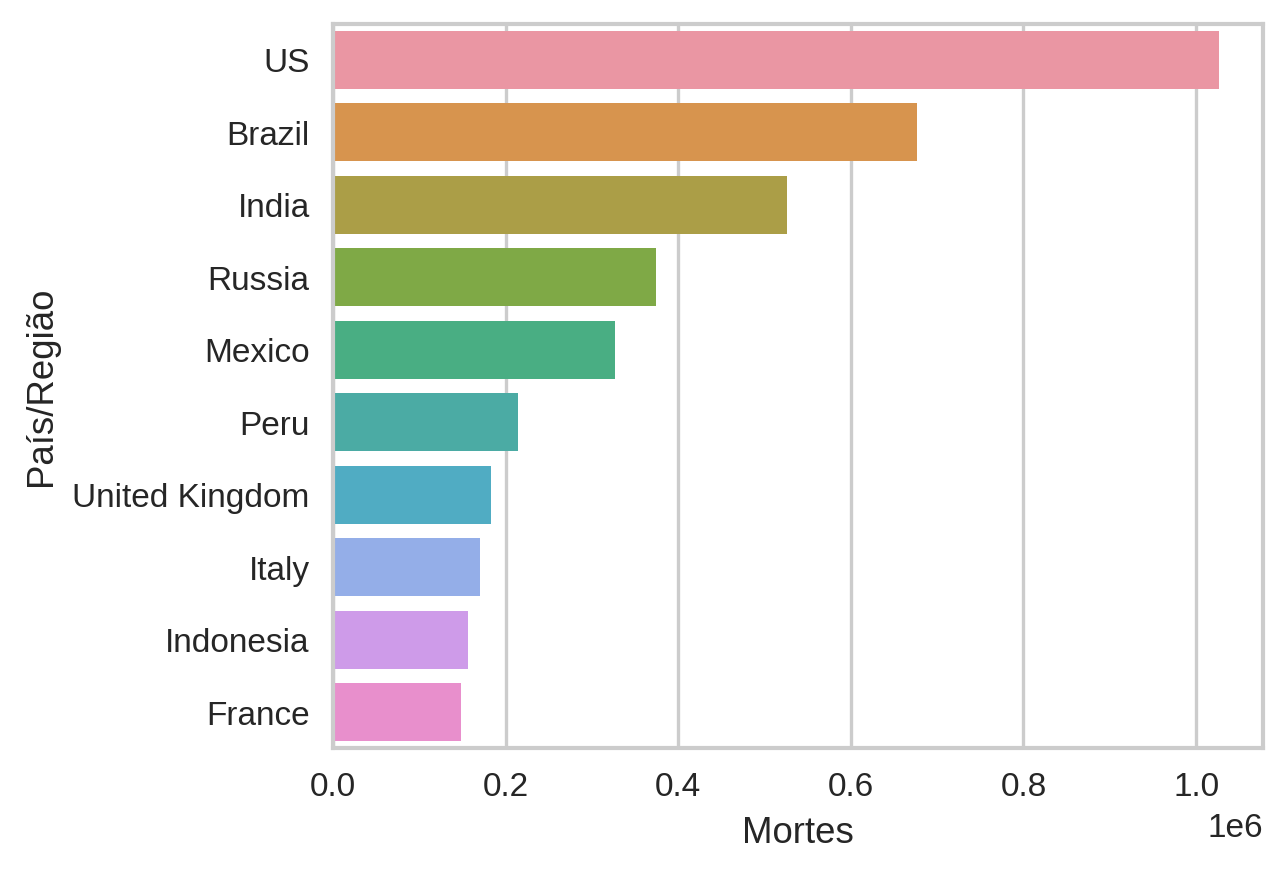

In [154]:
cols = deaths_df.keys()
deaths_sorted = deaths_df.sort_values(by=[deaths_df.columns[-1]], ascending=False).loc[:, [cols[1],cols[-1]]]
deaths_sorted.columns = ["País/Região", "Mortes"]
deaths_sorted.head(10)
plt.figure(figsize=(5, 4), dpi=120)
sns.barplot(data=deaths_sorted.head(10), y="País/Região", x="Mortes",)

# Calculo e extraçao dos dados

In [3]:
days = 365*2

cols = confirmed_df.keys()
local = confirmed_df.loc[:, cols[1]]
confirmed = confirmed_df.loc[:, cols[4]:cols[4+days]]
deaths = deaths_df.loc[:, cols[4]:cols[4+days]]

In [5]:
dates = confirmed.keys()
world_cases = []
total_deaths = [] 
mortality_rate = []


for i in dates:
    confirmed_sum = confirmed[i].sum()
    death_sum = deaths[i].sum()
    
    world_cases.append(confirmed_sum)
    total_deaths.append(death_sum)
    
    # calculate rates
    mortality_rate.append(death_sum/confirmed_sum)

world_cases    = np.array(world_cases   )
total_deaths   = np.array(total_deaths  )
mortality_rate = np.array(mortality_rate)

In [6]:
def daily_increase(data):
    d = [] 
    for i in range(len(data)):
        if i == 0:
            d.append(data[0])
        else:
            d.append(data[i]-data[i-1])
    return d 

def moving_average(data, window_size):
    moving_average = []
    for i in range(len(data)):
        if i + window_size < len(data):
            moving_average.append(np.mean(data[i:i+window_size]))
        else:
            moving_average.append(np.mean(data[i:len(data)]))
    return moving_average

# window size
window = 7

# confirmed cases
world_daily_increase = daily_increase(world_cases)
world_confirmed_avg= moving_average(world_cases, window)
world_daily_increase_avg = moving_average(world_daily_increase, window)

# deaths
world_daily_death = daily_increase(total_deaths)
world_death_avg = moving_average(total_deaths, window)
world_daily_death_avg = moving_average(world_daily_death, window)

In [7]:
local_daily_increase = np.array([daily_increase(confirmed.loc[i, :].to_numpy()) for i in range(len(confirmed))])
local_confirmed_avg = np.array([moving_average(confirmed.loc[i, :].to_numpy(), window) for i in range(len(confirmed))])
local_daily_increase_avg = np.array([moving_average(local_daily_increase[i], window) for i in range(len(confirmed))])

local_daily_death = np.array([daily_increase(deaths.loc[i, :].to_numpy()) for i in range(len(deaths))])
local_death_avg = np.array([moving_average(deaths.loc[i, :].to_numpy(), window) for i in range(len(deaths))])
local_daily_death_avg = np.array([moving_average(local_daily_death[i], window) for i in range(len(deaths))])

In [8]:
days_in_future = 10
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-days_in_future]

# Visualização da situação do mundo

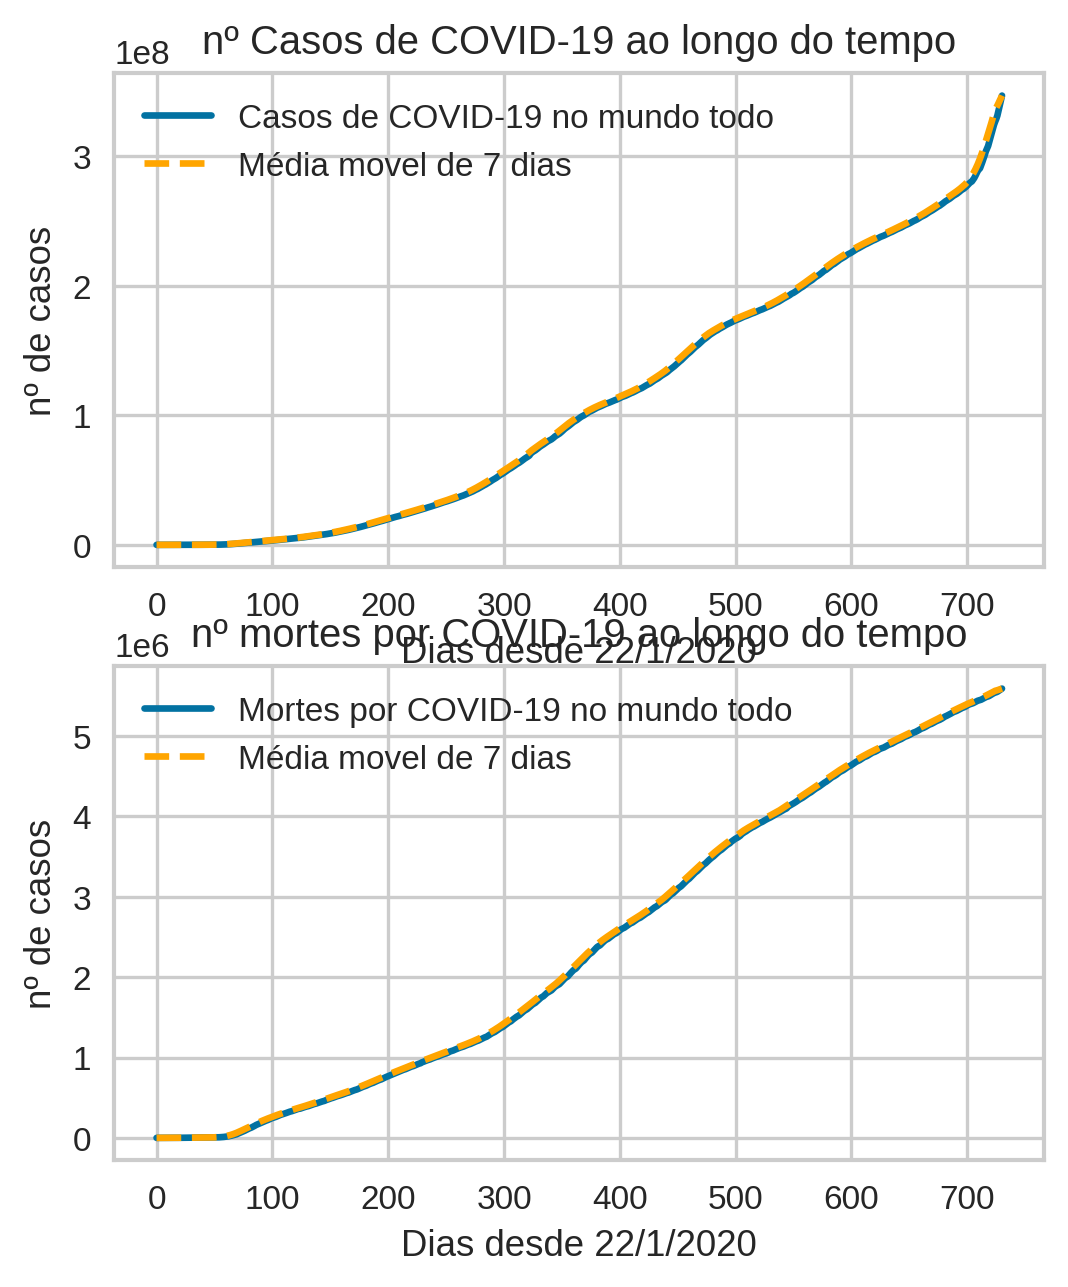

In [134]:
adjusted_dates = adjusted_dates.reshape(1, -1)[0]

plt.figure(figsize=(5, 6), dpi=120)

plt.subplot(2,1,1)
plt.plot(adjusted_dates, world_cases,         lw=2)
plt.plot(adjusted_dates, world_confirmed_avg, lw=2, linestyle='dashed', color='orange')

plt.title('nº Casos de COVID-19 ao longo do tempo')
plt.xlabel('Dias desde 22/1/2020')
plt.ylabel('nº de casos')
plt.legend(['Casos de COVID-19 no mundo todo', 'Média movel de {} dias'.format(window)])
plt.xticks()
plt.yticks()

plt.subplot(2,1,2)
plt.plot(adjusted_dates, total_deaths,    lw=2)
plt.plot(adjusted_dates, world_death_avg, lw=2, linestyle='dashed', color='orange')
plt.title('nº mortes por COVID-19 ao longo do tempo')
plt.xlabel('Dias desde 22/1/2020')
plt.ylabel('nº de casos')
plt.legend(['Mortes por COVID-19 no mundo todo', 'Média movel de {} dias'.format(window)])
plt.xticks()
plt.yticks()


plt.show()

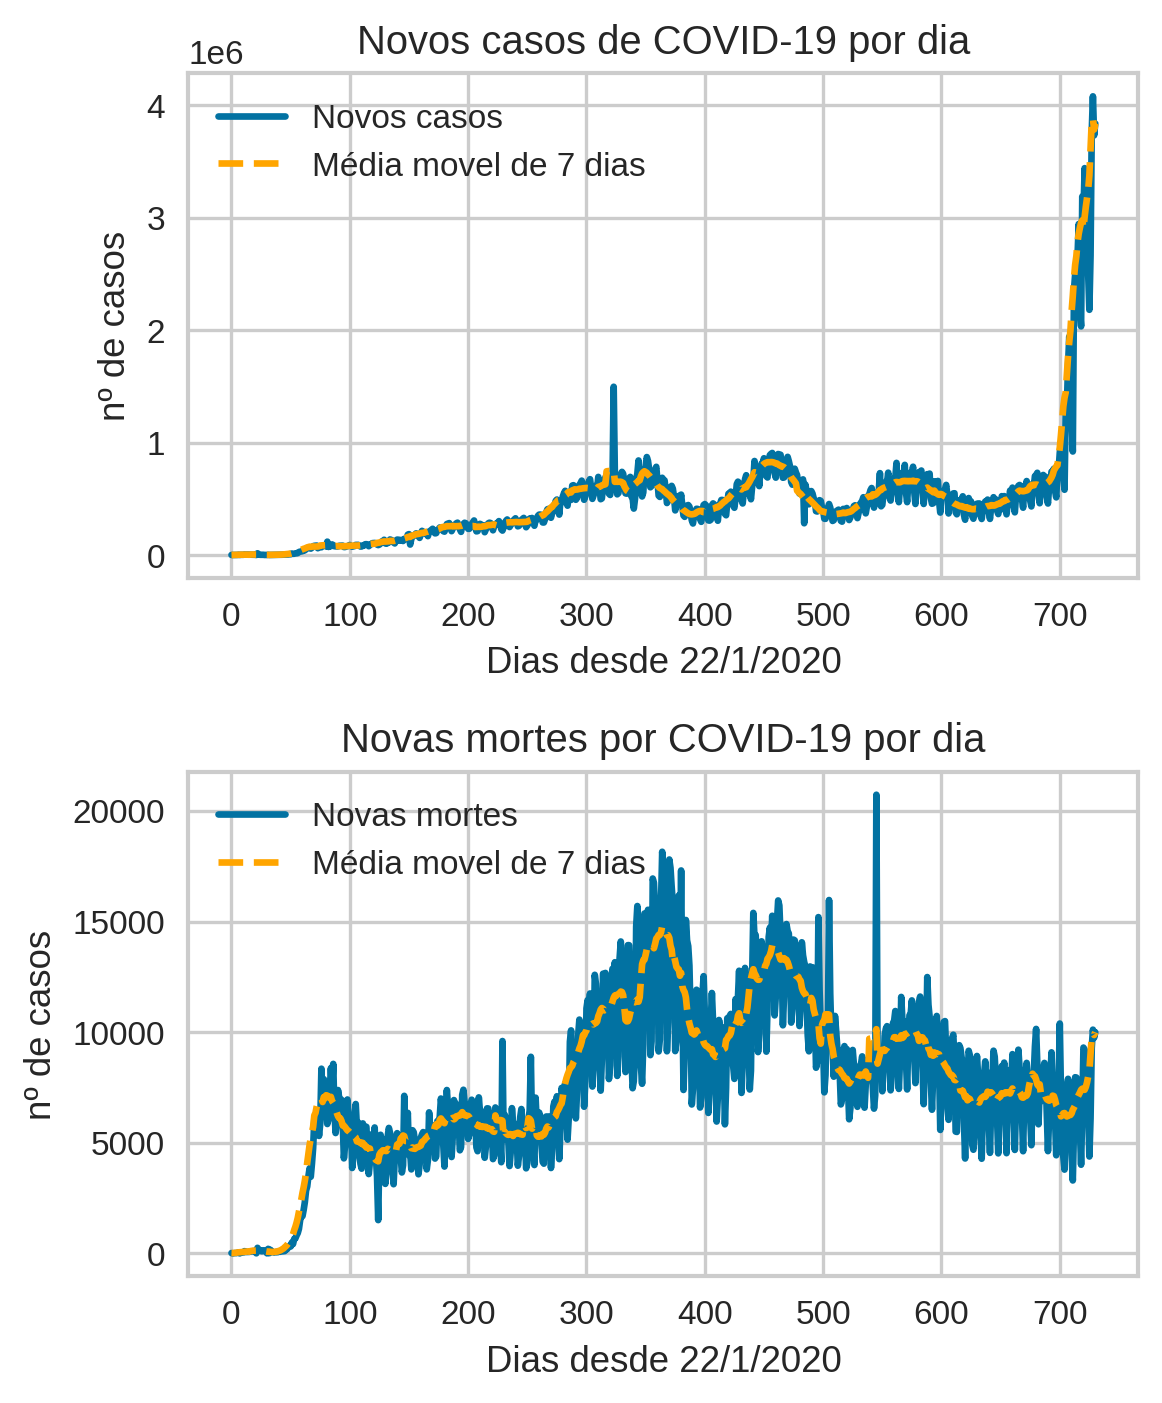

In [13]:
adjusted_dates = adjusted_dates.reshape(1, -1)[0]

plt.figure(figsize=(5, 6), dpi=120)

plt.subplot(2,1,1)
plt.plot(adjusted_dates, world_daily_increase,     lw=2)
plt.plot(adjusted_dates, world_daily_increase_avg, lw=2, linestyle='dashed', color='orange')

plt.title('Novos casos de COVID-19 por dia')
plt.xlabel('Dias desde 22/1/2020')
plt.ylabel('nº de casos')
plt.legend(['Novos casos', 'Média movel de {} dias'.format(window)])
plt.xticks()
plt.yticks()

plt.subplot(2,1,2)
plt.plot(adjusted_dates, world_daily_death,     lw=2)
plt.plot(adjusted_dates, world_daily_death_avg, lw=2, linestyle='dashed', color='orange')
plt.title('Novas mortes por COVID-19 por dia')
plt.xlabel('Dias desde 22/1/2020')
plt.ylabel('nº de casos')
plt.legend(['Novas mortes', 'Média movel de {} dias'.format(window)])
plt.xticks()
plt.yticks()

plt.tight_layout()
plt.show()

# Execução das técnicas de visualiçào e clusterização

In [72]:
original = np.concatenate((local_daily_increase_avg, local_daily_death_avg), axis=1)
data = original/np.max(original)

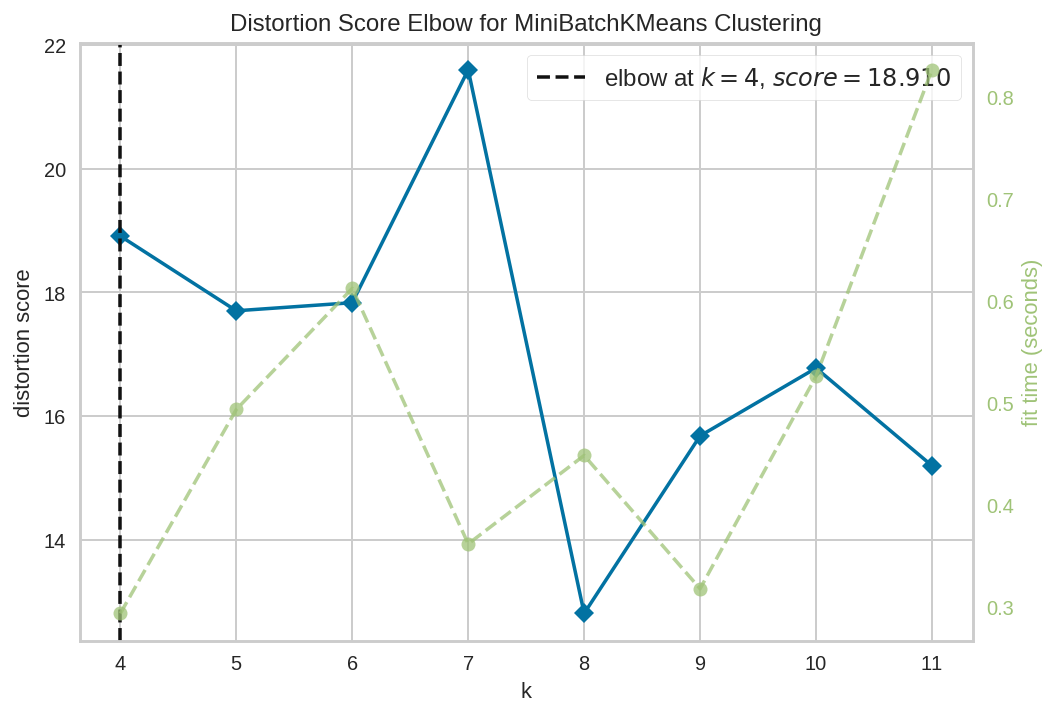

In [74]:
from sklearn.cluster import KMeans, SpectralClustering, MiniBatchKMeans
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = MiniBatchKMeans()
visualizer = KElbowVisualizer(
    model, k=(4,12)
)

visualizer.fit(data)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [68]:
def get_elbow(X):
    model = MiniBatchKMeans()
    visualizer = KElbowVisualizer(
        model, k=(4,12)
    )
    visualizer.fit(X) 
    return visualizer.elbow_value_

## PCA

Text(0, 0.5, 'Componente 2')

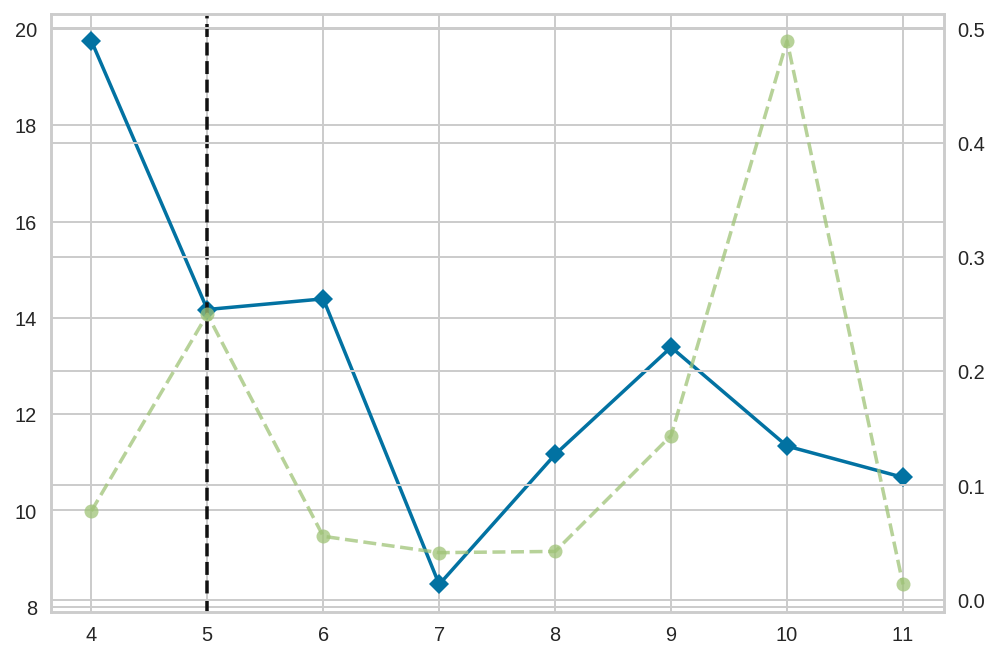

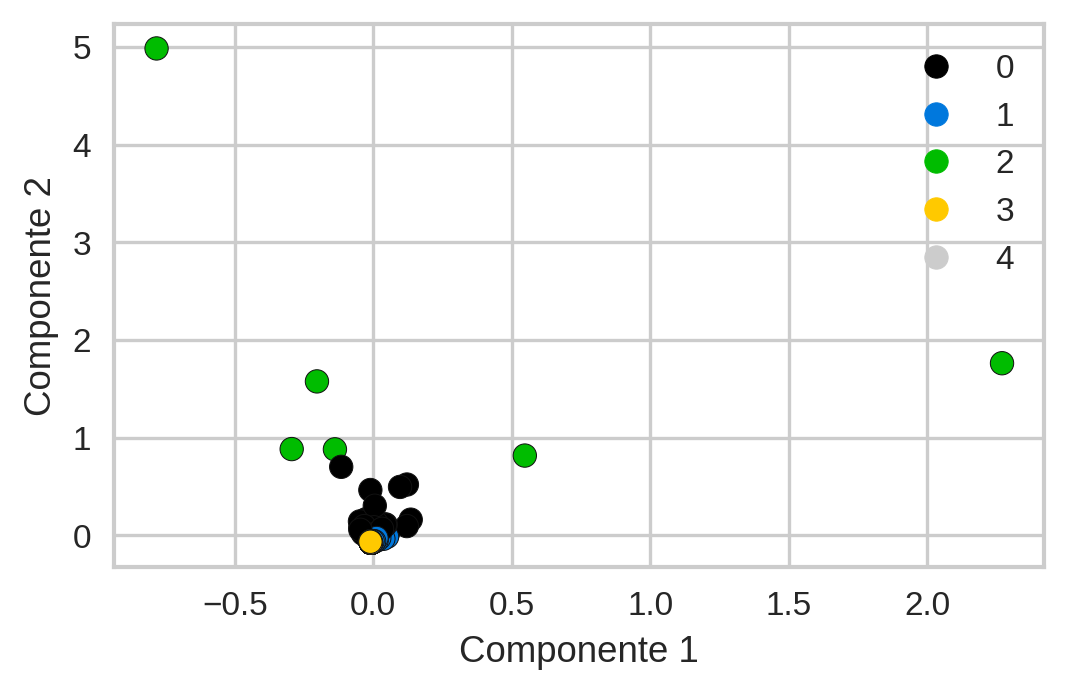

In [126]:
from sklearn import decomposition
from sklearn import datasets

X = decomposition.PCA(n_components=2).fit_transform(data)
clusters = get_elbow(X)
kmeans = MiniBatchKMeans(n_clusters=clusters).fit(X)
plt.figure(figsize=(5, 3), dpi=120)
scatter = plt.scatter(X[:, 1], X[:, 0], c=kmeans.labels_, cmap=plt.cm.nipy_spectral, edgecolor="k")
plt.legend(handles=scatter.legend_elements()[0], labels=set(kmeans.labels_))
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")

In [118]:
group_name = [[] for i in range(clusters)]
group_index = [[] for i in range(clusters)]

for i in range(len(kmeans.labels_)):
    g = kmeans.labels_[i]
    group_name[g].append(local.loc[i])
    group_index[g].append(i)

pd.DataFrame(group_name)

,0,1,2,3,4,5,6,7,8,9,...,213,214,215,216,217,218,219,220,221,222
0,Australia,Australia,Australia,Austria,Bangladesh,Belgium,Bolivia,Bulgaria,Canada,Canada,...,None,None,None,None,None,None,None,None,None,None
1,Afghanistan,Albania,Algeria,Andorra,Angola,Antarctica,Antigua and Barbuda,Armenia,Australia,Australia,...,United Kingdom,United Kingdom,Uzbekistan,Vanuatu,Venezuela,West Bank and Gaza,Winter Olympics 2022,Yemen,Zambia,Zimbabwe
2,Argentina,Brazil,Colombia,Germany,Israel,Italy,Mexico,Netherlands,Russia,Spain,...,None,None,None,None,None,None,None,None,None,None
3,France,India,US,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


## t-SNE

Text(0, 0.5, 'Componente 2')

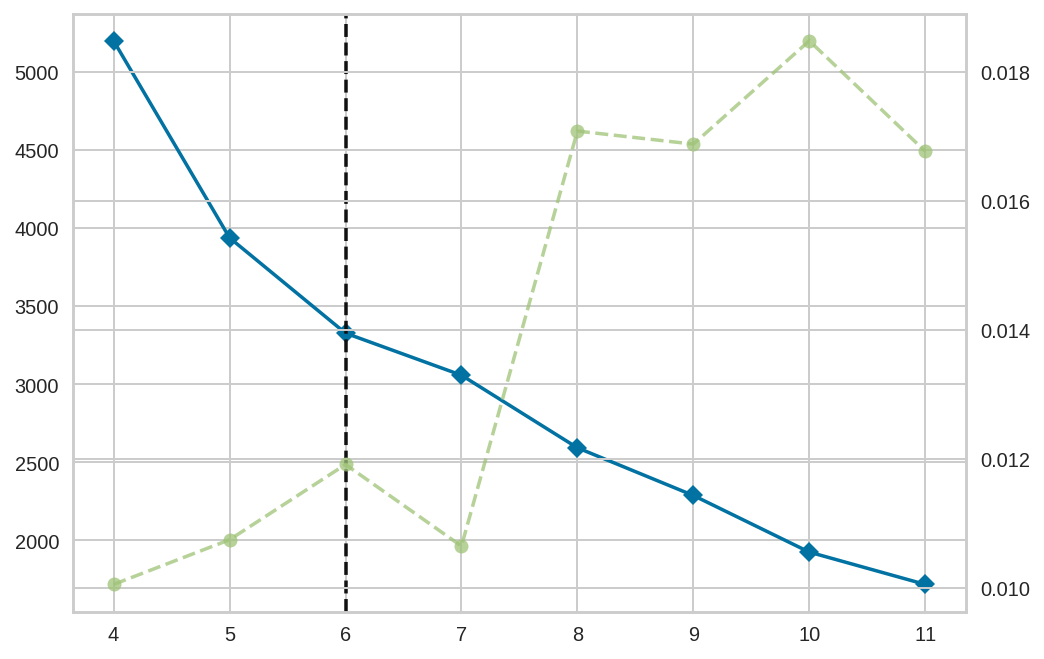

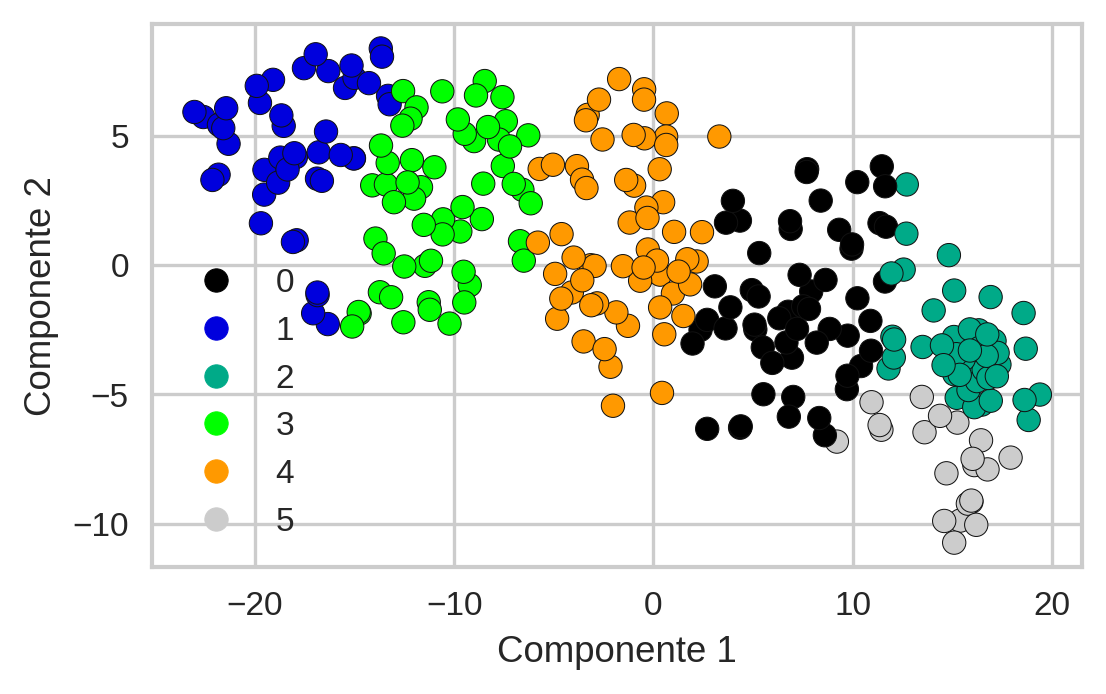

In [133]:
from sklearn.manifold import TSNE
X = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(data)
clusters = get_elbow(X)
kmeans = MiniBatchKMeans(n_clusters=clusters).fit(X)
plt.figure(figsize=(5, 3), dpi=120)
scatter = plt.scatter(X[:, 1], X[:, 0], c=kmeans.labels_, cmap=plt.cm.nipy_spectral, edgecolor="k")
plt.legend(handles=scatter.legend_elements()[0], labels=set(kmeans.labels_))
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")

In [132]:
group_name = [[] for i in range(clusters)]
group_index = [[] for i in range(clusters)]

for i in range(len(kmeans.labels_)):
    g = kmeans.labels_[i]
    group_name[g].append(local.loc[i])
    group_index[g].append(i)

pd.DataFrame(group_name)

,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
0,Australia,Bangladesh,Bolivia,Bulgaria,Burma,Canada,Canada,Canada,Costa Rica,Croatia,...,None,None,None,None,None,None,None,None,None,None
1,Central African Republic,China,China,China,China,China,China,China,China,China,...,None,None,None,None,None,None,None,None,None,None
2,Andorra,Angola,Australia,Australia,Australia,Bahamas,Barbados,Belize,Burundi,Cabo Verde,...,None,None,None,None,None,None,None,None,None,None
3,Antigua and Barbuda,Benin,Brunei,Burkina Faso,Canada,Canada,Canada,Chad,China,China,...,Tanzania,Timor-Leste,United Kingdom,United Kingdom,United Kingdom,United Kingdom,United Kingdom,United Kingdom,United Kingdom,Yemen
4,Argentina,Australia,Australia,Austria,Belgium,Brazil,Colombia,Czechia,Denmark,France,...,None,None,None,None,None,None,None,None,None,None
5,Albania,Armenia,Australia,Azerbaijan,Bahrain,Belarus,Bosnia and Herzegovina,Canada,Canada,Chile,...,None,None,None,None,None,None,None,None,None,None
6,Antarctica,Australia,Bhutan,Canada,Canada,Canada,Canada,China,China,China,...,United Kingdom,Vanuatu,Winter Olympics 2022,None,None,None,None,None,None,None
7,Afghanistan,Algeria,Botswana,Cambodia,Cameroon,Congo (Kinshasa),El Salvador,Eswatini,Fiji,Ghana,...,None,None,None,None,None,None,None,None,None,None


# UMAP

Text(0, 0.5, 'Componente 2')

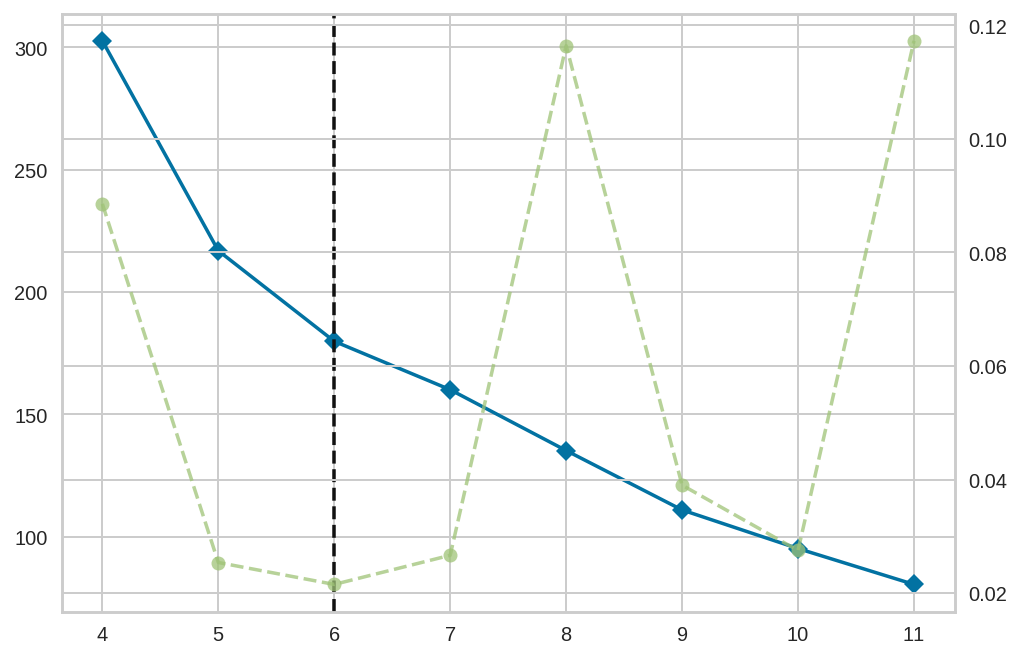

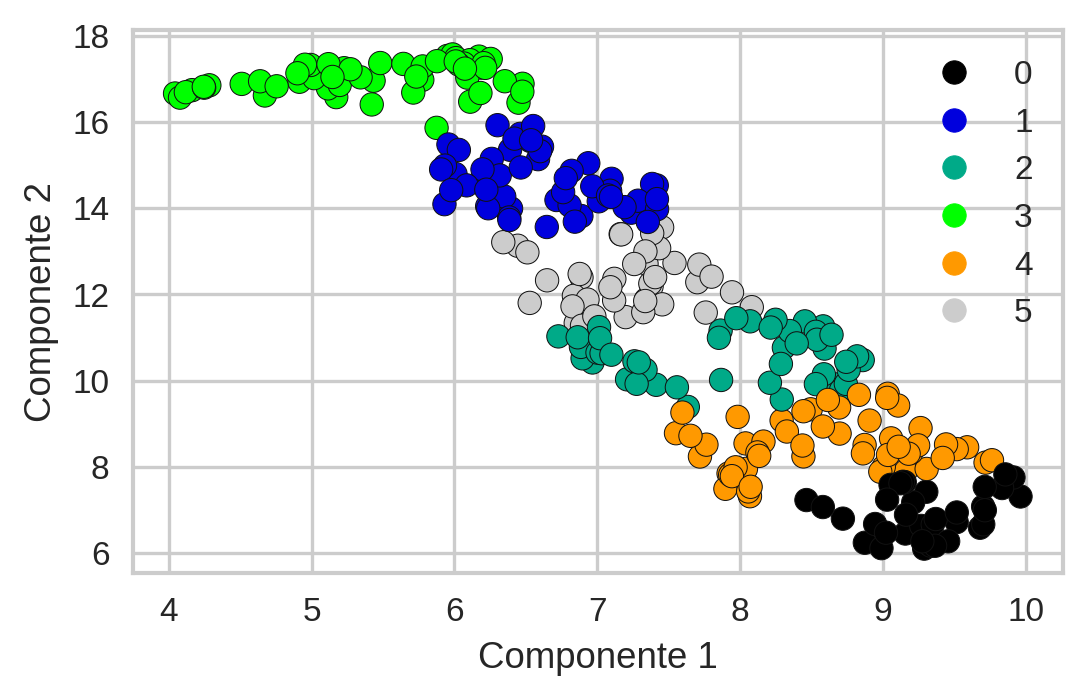

In [128]:
X = umap.UMAP().fit_transform(data)
clusters = get_elbow(X)
kmeans = MiniBatchKMeans(n_clusters=clusters).fit(X)
plt.figure(figsize=(5, 3), dpi=120)
scatter = plt.scatter(X[:, 1], X[:, 0], c=kmeans.labels_, cmap=plt.cm.nipy_spectral, edgecolor="k")
plt.legend(handles=scatter.legend_elements()[0], labels=set(kmeans.labels_))
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")

In [122]:
group_name = [[] for i in range(clusters)]
group_index = [[] for i in range(clusters)]

for i in range(len(kmeans.labels_)):
    g = kmeans.labels_[i]
    group_name[g].append(local.loc[i])
    group_index[g].append(i)

pd.DataFrame(group_name)

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,Albania,Algeria,Armenia,Australia,Azerbaijan,Bahrain,Bangladesh,Belarus,Bosnia and Herzegovina,Botswana,...,Uruguay,Uzbekistan,Venezuela,West Bank and Gaza,None,None,None,None,None,None
1,Antigua and Barbuda,Benin,Bhutan,Brunei,Burkina Faso,Canada,Canada,Canada,Canada,Central African Republic,...,Tanzania,Timor-Leste,United Kingdom,United Kingdom,United Kingdom,United Kingdom,United Kingdom,United Kingdom,United Kingdom,Yemen
2,Antarctica,Australia,Canada,Canada,Canada,China,China,China,China,China,...,United Kingdom,United Kingdom,Vanuatu,Winter Olympics 2022,None,None,None,None,None,None
3,Afghanistan,Andorra,Angola,Australia,Australia,Australia,Bahamas,Barbados,Belize,Burundi,...,Seychelles,Sudan,Suriname,Togo,Trinidad and Tobago,Uganda,United Kingdom,United Kingdom,Zambia,Zimbabwe
4,Argentina,Australia,Australia,Australia,Austria,Belgium,Bolivia,Brazil,Bulgaria,Canada,...,United Kingdom,Vietnam,None,None,None,None,None,None,None,None


## Rede neural

### Construção da rede

In [49]:
import keras
from keras import layers


encoding_dim = 2

input_lay = keras.Input(shape=(data.shape[1],))
seq1      = layers.Dense(128, activation='sigmoid')(input_lay)
encoded   = layers.Dense(encoding_dim, activation='linear')(seq1)
seq2      = layers.Dense(128, activation='sigmoid')(encoded)
decoded   = layers.Dense(data.shape[1], activation='linear')(seq2)


autoencoder = keras.Model(input_lay, decoded)

encoder = keras.Model(input_lay, encoded)


encoded_input = keras.Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-2]
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

In [50]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 1462)]            0         
                                                                 
 dense_16 (Dense)            (None, 128)               187264    
                                                                 
 dense_17 (Dense)            (None, 2)                 258       
                                                                 
 dense_18 (Dense)            (None, 128)               384       
                                                                 
 dense_19 (Dense)            (None, 1462)              188598    
                                                                 
Total params: 376,504
Trainable params: 376,504
Non-trainable params: 0
_________________________________________________________________


### Treino

In [ ]:
x_train = data
autoencoder.fit(x_train, x_train,
                epochs=500,
                batch_size=32,
                shuffle=True)

### Projeção

Text(0, 0.5, 'Componente 2')

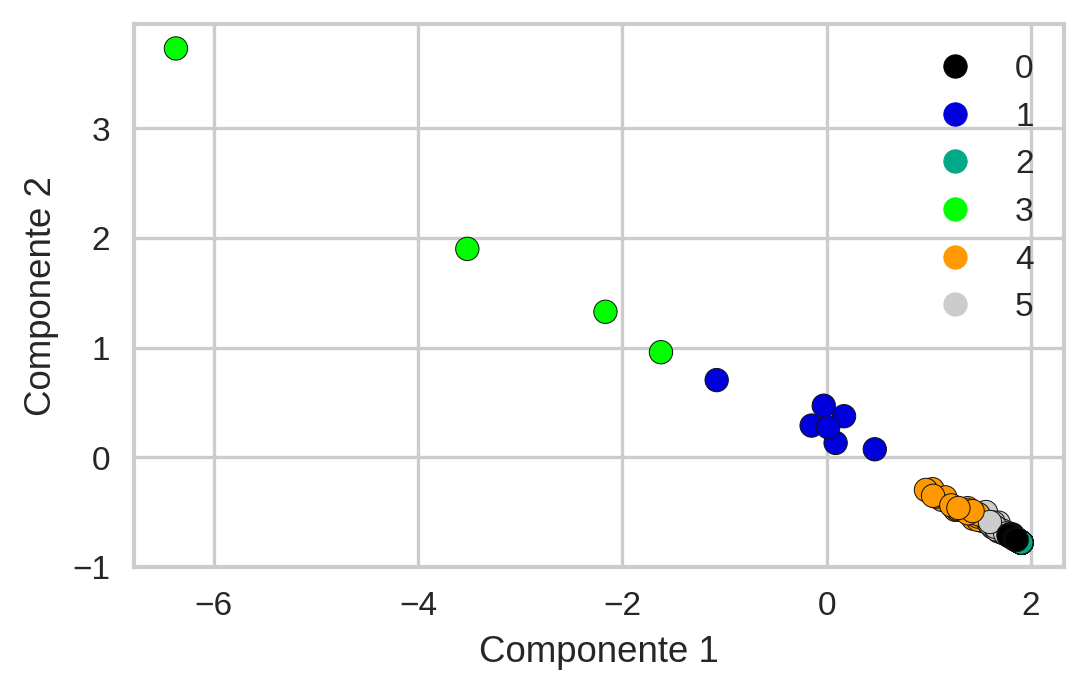

In [129]:
X = encoder.predict(x_train)
clusters = 6
kmeans = MiniBatchKMeans(n_clusters=clusters).fit(X)
plt.figure(figsize=(5, 3), dpi=120)
scatter = plt.scatter(X[:, 1], X[:, 0], c=kmeans.labels_, cmap=plt.cm.nipy_spectral, edgecolor="k")
plt.legend(handles=scatter.legend_elements()[0], labels=set(kmeans.labels_))
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")

In [124]:
group_name = [[] for i in range(clusters)]
group_index = [[] for i in range(clusters)]

for i in range(len(kmeans.labels_)):
    g = kmeans.labels_[i]
    group_name[g].append(local.loc[i])
    group_index[g].append(i)

pd.DataFrame(group_name)

,0,1,2,3,4,5,6,7,8,9,...,181,182,183,184,185,186,187,188,189,190
0,Albania,Australia,Australia,Azerbaijan,Bangladesh,Belarus,Bolivia,Bosnia and Herzegovina,Bulgaria,Burma,...,None,None,None,None,None,None,None,None,None,None
1,Afghanistan,Algeria,Andorra,Angola,Antarctica,Antigua and Barbuda,Armenia,Australia,Australia,Australia,...,United Kingdom,United Kingdom,United Kingdom,Uzbekistan,Vanuatu,Venezuela,West Bank and Gaza,Winter Olympics 2022,Yemen,Zimbabwe
2,Argentina,Brazil,Germany,India,Italy,Russia,Spain,Turkey,None,None,...,None,None,None,None,None,None,None,None,None,None
3,Australia,Belgium,Denmark,Greece,Israel,Mexico,Netherlands,Poland,Portugal,Switzerland,...,None,None,None,None,None,None,None,None,None,None
4,Australia,Austria,Canada,Canada,Colombia,Czechia,Hungary,Indonesia,Iran,Ireland,...,None,None,None,None,None,None,None,None,None,None
5,France,US,United Kingdom,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
